In [1]:
# Load packages
import os
import sys

import flopy
import matplotlib.pyplot as plt
import numpy as np
import ipywidgets as widgets
from ipywidgets import interactive

main_dir = os.getcwd()
os.chdir("..")
sys.path.append(os.getcwd())
from topic_func.EX_Modpath import *

sys.path.append("C:/GW_GitHub/TUD_GW_MOD/basic_func")
from basic_func.postprocess import *

In [2]:
# Set the default figure size
plt.rcParams['figure.figsize'] = (10, 4)

In [3]:
# Create the model object (update autom. the model when parameters change)
interactive_plot = interactive(predefined_model, 
                               hk = hk_slider,
                               )
# Show the results
display(interactive_plot)

c:\ProgramData\Anaconda3\envs\tud_igw_mod\Lib\site-packages\ipywidgets\widgets\interaction.py:43: DeprecationWarning: `ipykernel.pylab.backend_inline` is deprecated, directly use `matplotlib_inline.backend_inline`
  from ipykernel.pylab.backend_inline import flush_figures


interactive(children=(FloatLogSlider(value=1e-05, continuous_update=False, description='Kh [m/s]:', max=-3.0, …

## Script for interactive plot 

adding Package:  DIS
plotting DIS package Util2d instance: top
plotting DIS package Util3d instance: botm
adding Package:  BAS6
adding Package:  CHD
plotting CHD package MfList instance: stress_period_data
Adding 01_EX.cbc (unit=53) to the output list.
adding Package:  LPF
adding Package:  PCG
Adding 01_EX.hds (unit=51) to the output list.
adding Package:  OC

Writing packages:
   Package:  DIS
   Package:  BAS6
   Package:  CHD
   Package:  LPF
   Package:  PCG
   Package:  OC
 

01_EX MODEL DATA VALIDATION SUMMARY:
  No errors or warnings encountered.

  Checks that passed:
    Unit number conflicts
    Compatible solver package
    DIS package: zero or negative thickness
    DIS package: thin cells (less than checker threshold of 1.0)
    DIS package: nan values in top array
    DIS package: nan values in bottom array
    BAS6 package: isolated cells in ibound array
    BAS6 package: Not a number
    CHD package: BC indices valid
    CHD package: not a number (Nan) entries
    CHD p

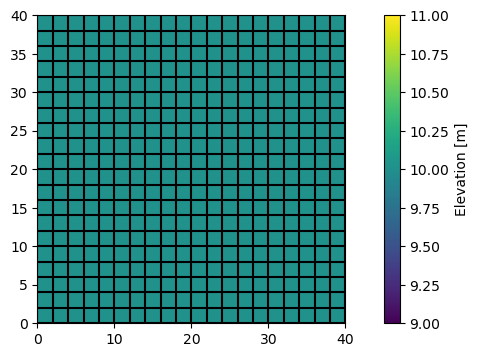

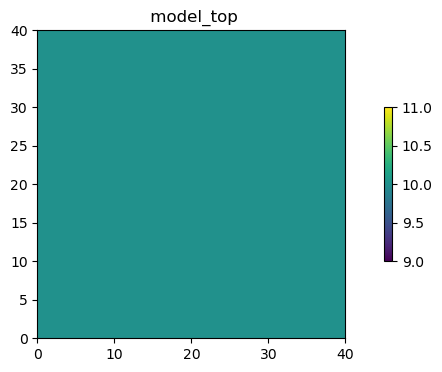

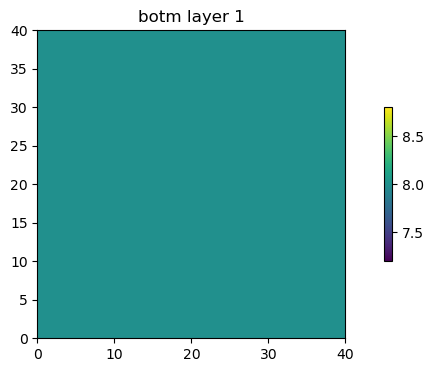

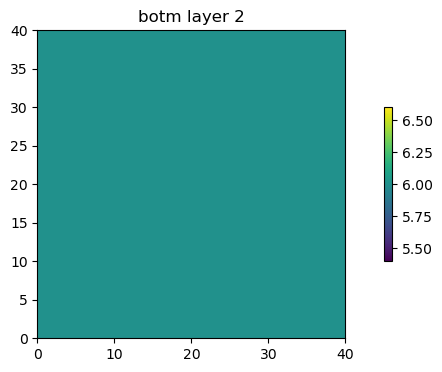

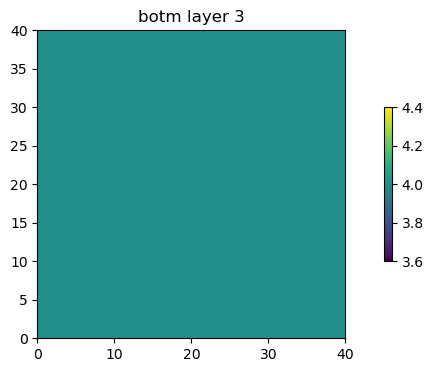

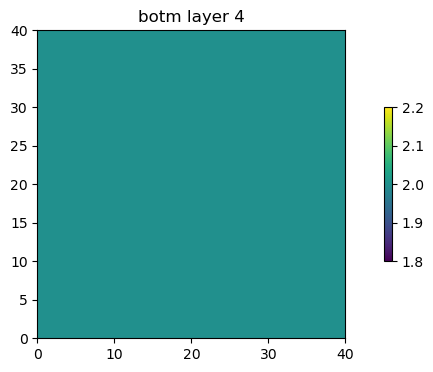

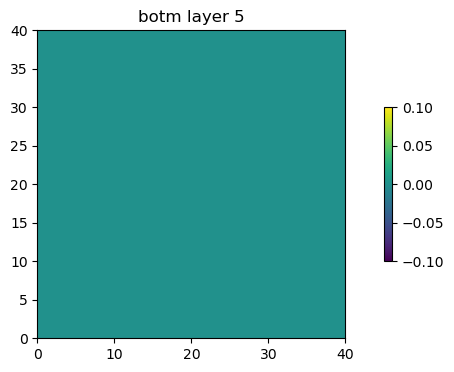

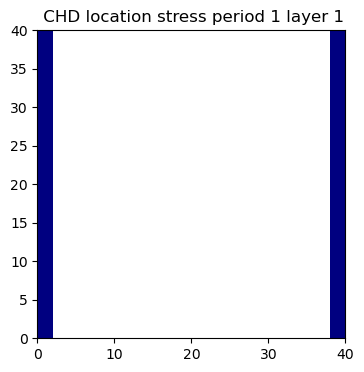

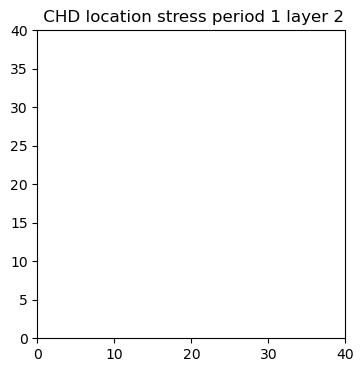

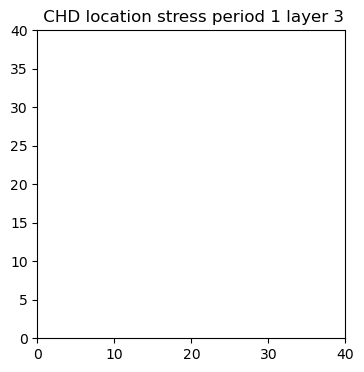

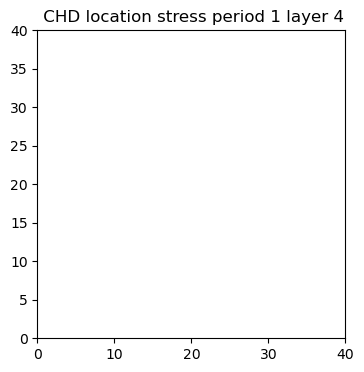

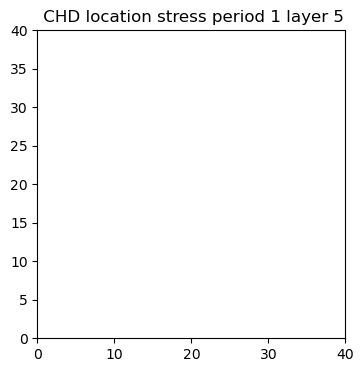

In [4]:
# Create a MODFLOW-2005 model
model_ws = os.path.join(os.getcwd(), "01_EX")
modelname = "01_EX"
mf = flopy.modflow.Modflow(modelname=modelname, exe_name="mf2005", 
                           verbose=True, model_ws=model_ws)

celGlo = 2 # Grid cell size in meters
cells = 20 # Number of cells in x and y direction
nlay = 5 # Number of layers
top = 10 # Top elevation
if nlay > 1:
     botm = np.linspace(top, 0, nlay+1)[1:] # Bottom elevation of each layer
else:
     botm = [0]

nper = 1 # Number of stress periods
nstp = np.ones(nper) # Number of time steps in each stress period
perlen = 1 # [1., 3600., 86400.] # Length of each stress period
steady = np.zeros(nper, dtype=np.bool_) # Is each stress period steady state?
steady[0] = 1 # Ensure stationary first stress period

'''DIS'''
# Create the discretization package
dis = flopy.modflow.ModflowDis(model = mf, # The flopy model object
                               itmuni=1, # Time unit (1 = seconds)
                               lenuni=2, # Length unit (2 = meters)
                               nlay=nlay, # Number of layers
                               nrow=cells,  # Number of rows
                               ncol=cells,  # Number of columns
                               delr= celGlo,  # Column spacing
                               delc= celGlo, # Row spacing
                               top= top, # Top elevation
                               botm= botm, # Bottom elevation of each layer
                               nper=nper, # Number of stress periods
                               perlen= perlen, # Simulation time
                               nstp = nstp, # Number of time steps
                               steady = steady # Steady state simulation
)

# Plot the discretization
mapview = flopy.plot.PlotMapView(model=mf, layer=0)
quadmesh = mapview.plot_array(dis.top.array)
cbar = plt.colorbar(quadmesh)
cbar.ax.set_ylabel('Elevation [m]')
mapview.plot_grid(color='black')

mf.dis.plot()

'''BAS'''
# Define the basic package
ibound = np.ones((mf.dis.ncol, mf.dis.nrow), dtype=np.int32) # Create ibound array
strt = np.ones((mf.dis.ncol, mf.dis.nrow), dtype=np.float32) * mf.dis.top.array.min()/2 # Create starting head array
# Define the basic package
bas = flopy.modflow.ModflowBas(mf, ibound = ibound, strt=strt)


'''CHD'''
# Define the left boundary
left_row = np.arange(0, mf.dis.nrow).tolist()
left_col = [0] *  mf.dis.ncol

# Define the right boundary
right_row = np.arange(0, mf.dis.nrow).tolist()
right_col = [mf.dis.ncol - 1] * mf.dis.nrow

# Define the heads
left_chd = 9.0
right_chd = 9.5

# Write the stress period data
spd_list = []
for kper in range(mf.dis.nper):
    spd_kper = []
    for lay in range(1):
            for row, col in zip(left_row, left_col):
                 # {0: [[lay, row, col, shead, ehead],
                #print(row, col)
                spd_layer = [[lay, row, col, 
                              left_chd, left_chd]]
                spd_kper.extend(spd_layer)
            for row, col in zip(right_row, right_col):
                spd_layer = [[lay, row, col, 
                              right_chd, right_chd]]
                spd_kper.extend(spd_layer)
    spd_list.append(spd_kper)
stress_period_data = {kper: spd_list[kper] for kper in range(mf.dis.nper)}

# Define the CHD package
chd = flopy.modflow.mfchd.ModflowChd(mf,
                                     stress_period_data=stress_period_data)

# Plot the CHD package
mf.chd.plot()

'''RCH'''
# Define the RCH package (optional)
#rch = flopy.modflow.ModflowRch(mf, rech=5e-8)  # Example recharge value 

'''LPF'''
lpf = flopy.modflow.ModflowLpf(mf, hk=1e-5, vka=1e-6, ipakcb=53)

'''PCG'''
# Define the solver package
pcg = flopy.modflow.ModflowPcg(mf)

'''OC'''
# Define the output control package
per_dict = {(kper,0): ['print head', 'save head', 'save budget'] for kper in range(mf.dis.nper)}
# create output control file using dictionary
oc = flopy.modflow.ModflowOc(mf, stress_period_data=per_dict)

mf.write_input() 
mf.check()
success, buff = mf.run_model(silent=False)

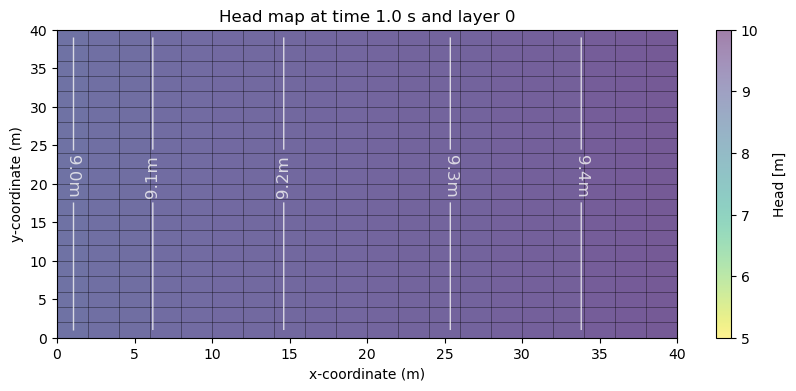

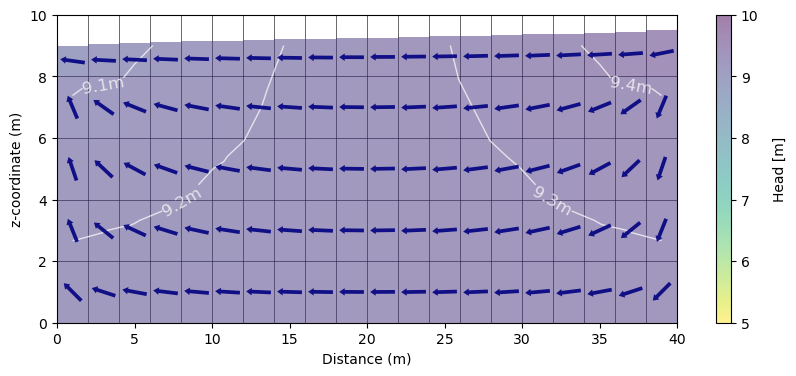

In [5]:
hds_name = modelname + ".hds"
cbc_name = modelname + ".cbc"

hdobj = flopy.utils.HeadFile(os.path.join(model_ws, hds_name))
cbb = flopy.utils.CellBudgetFile(os.path.join(model_ws, cbc_name))

# Define the settings for the plot
settings = {'cmap': 'viridis_r',
            'cmap_show': True,
            'vmin': 5,
            'vmax': 10,
            'cmap_alpha': 0.5,
            'cbar_show': True,
            'cbar_label': 'Head [m]',
            'masked_values': [-1.e+20, -2.e+20],
            'cbar_shrink': 1,
            'contour_colors' : 'whitesmoke',
            'cbar_rotation': 90,
            'cbar_labelpad': 10,
            'contourlabel_format': '%.1fm',
            'normalize' : True,
            'vector_alpha': 0.9,
            'vector_color': 'navy',
            'vector_scale': 25,
            'istep' : 1,
            'jstep' : 1,
            'hstep' : 1,}

levels = np.linspace(settings['vmin'], settings['vmax'], 
                     (settings['vmax'] - settings['vmin']) *10 + 1)

col = 5
row = 10

# Plot the head
mf_plot = plot_model(model = mf, layer = 0, time = mf.dis.get_totim()[0],
                     hdobj = hdobj, cbb = cbb, settings = settings)
fig, ax = plt.subplots()
mf_plot.head_map(ax=ax)
mf_plot.contour_map(ax=ax, levels = levels)

# Cross section
fig, ax = plt.subplots()
mf_plot.crosssection_map(ax=ax, levels = levels, line={'row': row})


adding Package:  MPBAS
adding Package:  MPSIM

Writing packages:
   Package:  MPBAS
   Package:  MPSIM
 
FloPy is using the following executable to run the model: ..\..\..\..\WRDAPP\mpath7.exe

MODPATH Version 7.2.001   
Program compiled Dec 22 2017 11:11:36 with IFORT compiler (ver. 16.0.0)         
 
 
Run particle tracking simulation ...
Processing Time Step     1 Period     1.  Time =  1.00000E+00  Steady-state flow                                                    

Particle Summary:
         0 particles are pending release.
         0 particles remain active.
         0 particles terminated at boundary faces.
         0 particles terminated at weak sink cells.
         0 particles terminated at weak source cells.
         7 particles terminated at strong source/sink cells.
         0 particles terminated in cells with a specified zone number.
         0 particles were stranded in inactive or dry cells.
         0 particles were unreleased.
         0 particles have an unknown st

C:\GW_GitHub/TUD_GW_MOD/basic_func\basic_func\postprocess.py:685: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colormap = plt.cm.get_cmap(cmap)


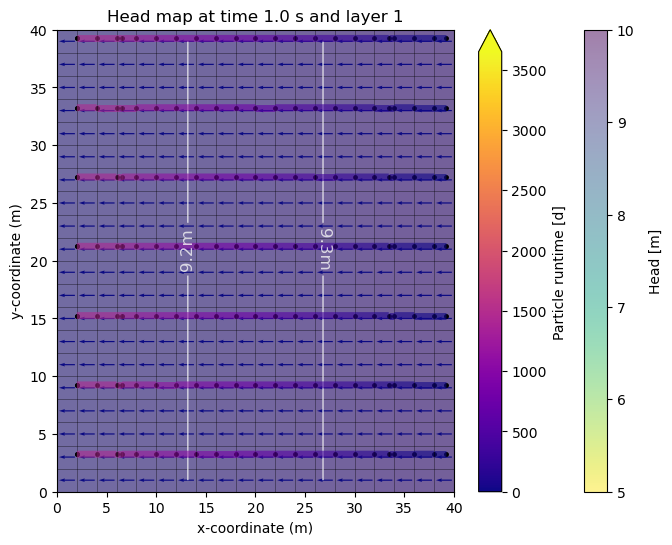

In [6]:
# Perform particle tracking

data = [(0, int(round(mf.dis.nrow / 2, 0)), int(round(mf.dis.ncol / 2, 0)))]
dtype = [('k', '<i4'), ('i', '<i4'), ('j', '<i4')]
cell = np.rec.array(data, dtype=dtype)

localx, localy, localz, partlocs = partlocs_structured_grid(
    mf,
    #cell, 
    mf.chd.stress_period_data.data[0][mf.dis.nrow : mf.dis.nrow * 2],
    PointsOnCircle(r = 0.25, N = 1),
    d8 = False,
    steps = 3) # each

#localz = [0]
#localz = [0] * mf.chd.stress_period_data.data[0].shape[0]

particledata = flopy.modpath.ParticleData(partlocs,
                                          structured = True,
                                          localx = localx,
                                          localy = localy,
                                          localz = localz,
                                          timeoffset = 0,
                                          drape = 0)

pg = flopy.modpath.ParticleGroup(particledata=particledata)

mp = flopy.modpath.Modpath7(modelname = f"{modelname}_modpath",
                            model_ws = model_ws,
                            flowmodel = mf,
                            headfilename = hds_name, 
                            budgetfilename = cbc_name,
                            exe_name = 'mpath7.exe',
                            verbose=True
                           )

mpbas = flopy.modpath.Modpath7Bas(mp, porosity=0.3)

mpsim = flopy.modpath.Modpath7Sim(mp,
                                  particlegroups = pg,
                                  simulationtype='pathline', #'combined',
                                  #weaksinkoption='pass_through',
                                  weaksourceoption = 'pass_through',
                                  stoptimeoption = 'extend',#'specified',
                                  #stoptime = 50 * 86400.,
                                  trackingdirection = 'forward',
                                  )

mp.write_input()
mp.run_model(silent = False)

mppth_path = os.path.join(model_ws, f"{modelname}_modpath.mppth")

# Create a plot
fig, ax = plt.subplots(figsize = (8,6))    

for i, t in enumerate(mf.dis.get_totim()[0:1]):
   
    mf_plot_ss = plot_model(model = mf, layer = 1, time = t,
                           hdobj = hdobj, cbb = cbb, settings = settings)
                          
    mf_plot_ss.head_map(ax=ax)
    mf_plot_ss.contour_map(ax=ax, levels = levels)
    mf_plot_ss.vector_map(ax=ax, vec = 'specific')
    
plot_pathlines_col(mppth_path = mppth_path, lw  = 5,
               ax = ax, cmap = 'plasma', vmin = 0, vmax = 86400*365*10, label = 'Particle runtime [d]')

C:\GW_GitHub/TUD_GW_MOD/basic_func\basic_func\postprocess.py:1278: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colormap = plt.cm.get_cmap(cmap)


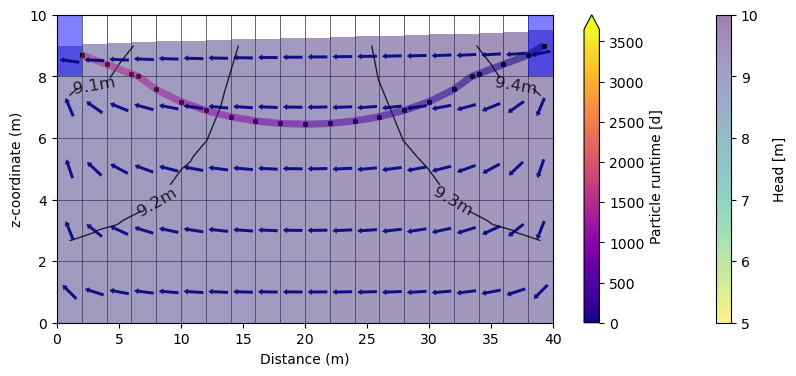

In [7]:
# Cross section
fig, ax = plt.subplots()
mf_plot.crosssection_map(ax=ax, levels=levels ,
                         line={'row': row}, contour_colors = 'black')

plot_pathlines_col_cross(mppth_path = mppth_path, lw  = 5,
               ax = ax, cmap = 'plasma', vmin = 0, vmax = 86400*365*10, label = 'Particle runtime [d]')

modelxsect = flopy.plot.PlotCrossSection(model=mf, 
                                         line={'row': row}, ax=ax)

modelxsect.plot_bc("CHD", color="Blue", alpha = 0.5)
